In [1]:
# Import packages
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

In [2]:
# Load data
df = pd.read_csv("train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
df.duplicated().sum()

0

In [5]:
df.isna().sum().sum()

7829

---
**Observations:** Our target variable is 'SalePrice'. And although this dataset contains a mix of numeric, categorical and missing features, TensorFlow Decision Forests supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models.

---

In [6]:
# Remove 'Id' column
df = df.drop("Id", axis = 1)

In [7]:
# 'SalePrice' distribution
df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

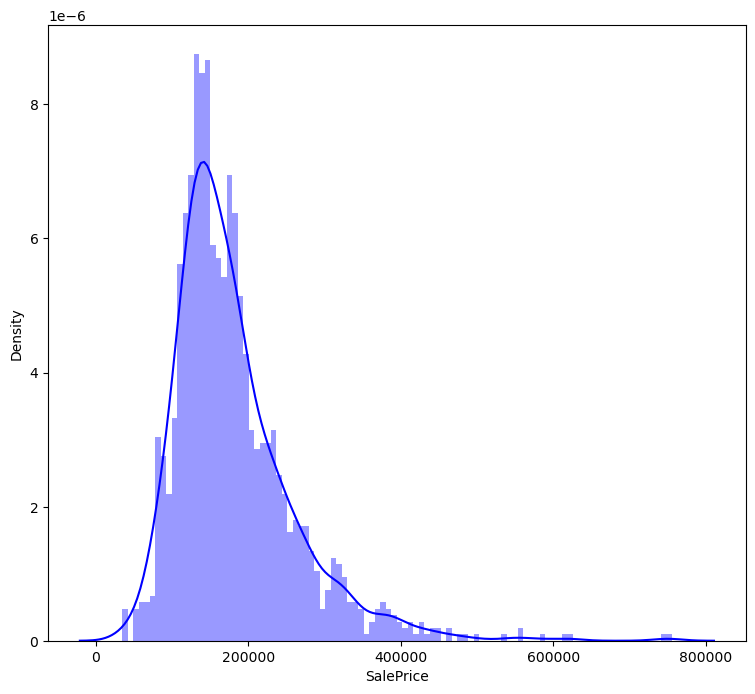

In [8]:
plt.figure(figsize = (9, 8))
sns.distplot(df["SalePrice"], color = "blue", bins = 100, hist_kws = {"alpha": 0.4});

---
**Observations:** We can see here that the majority of houses are sold for under $200,000. We do have outliers towards the right tail of the distribution.

---

In [9]:
# Separate numeric features 
df_num = df.select_dtypes(include = ["float64", "int64"])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


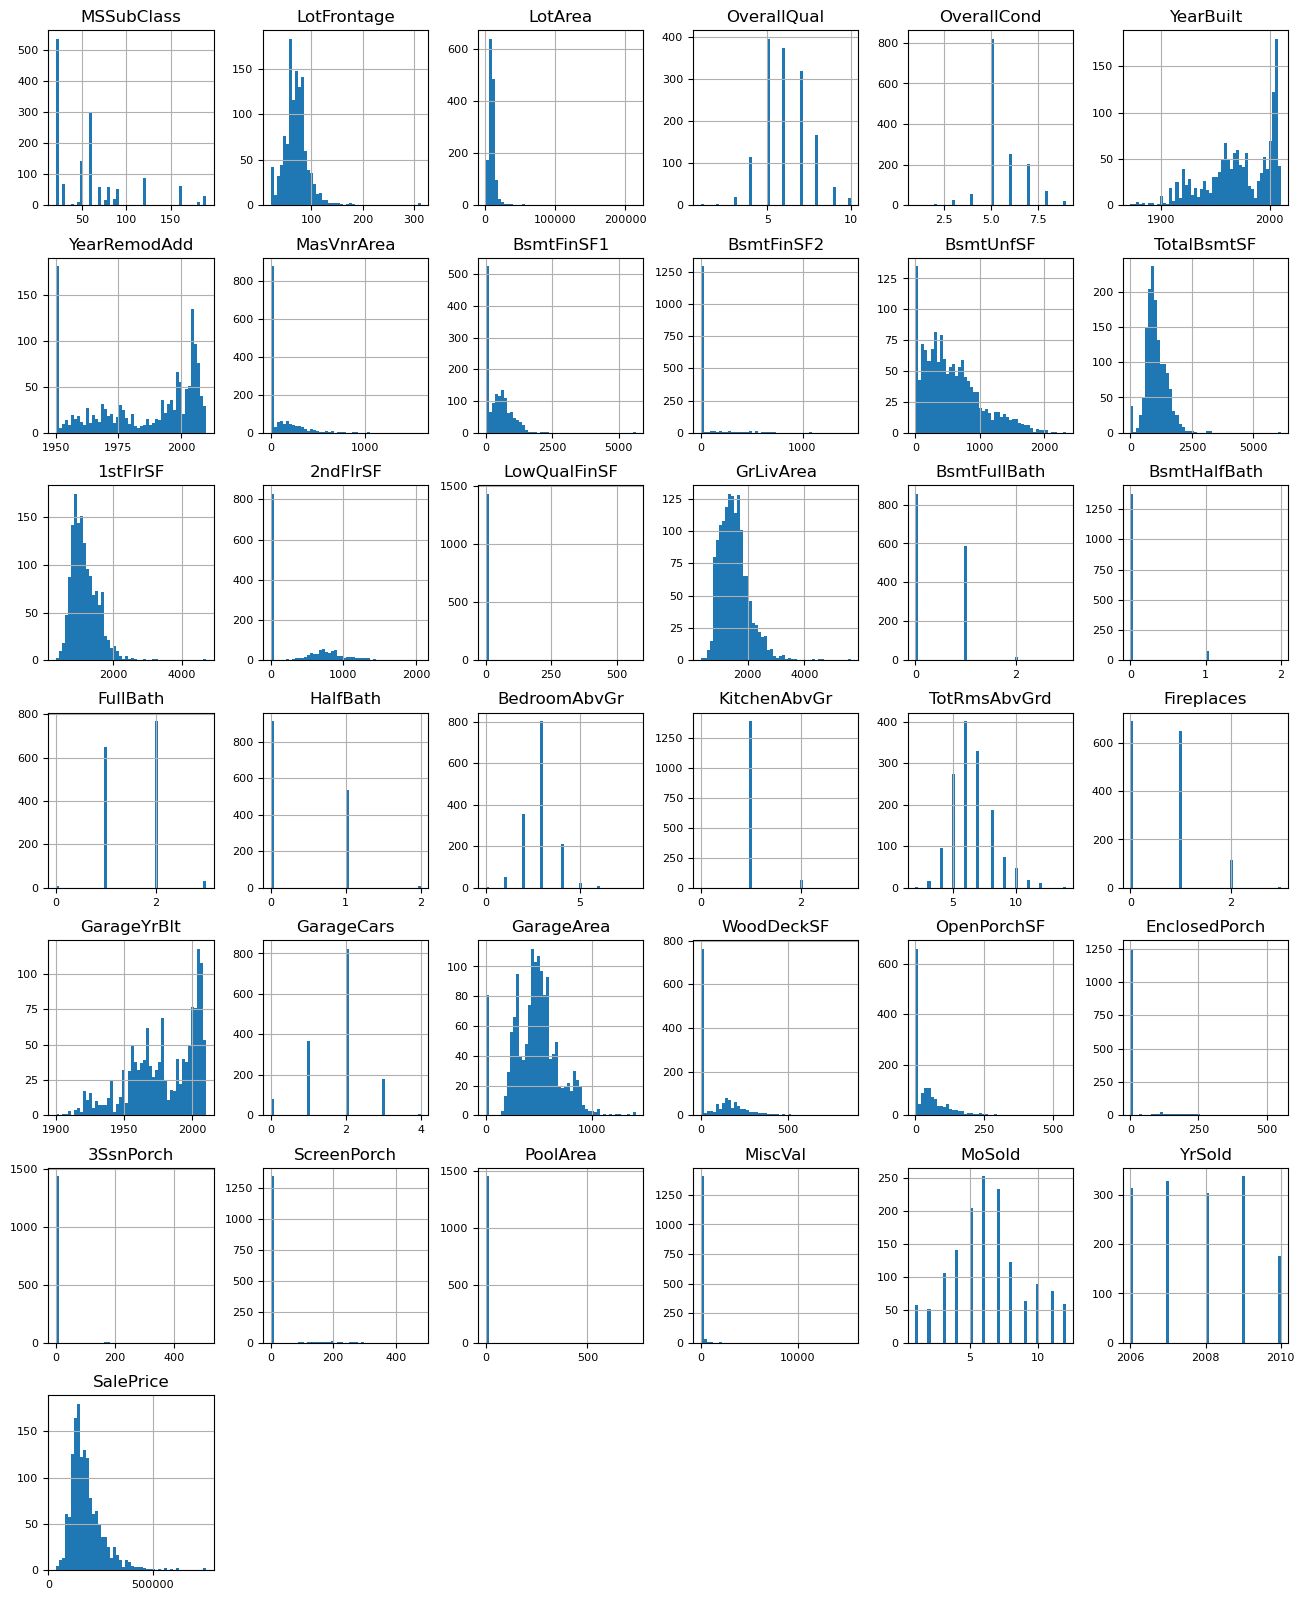

In [10]:
df_num.hist(figsize = (16, 20), bins = 50, xlabelsize = 8, ylabelsize = 8);

In [11]:
# Split data into train and test sets
def split_dataset(dataset, test_ratio = 0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(df)
print("{} examples in training, {} examples in testing.".format(len(train_ds_pd), len(valid_ds_pd)))

1006 examples in training, 454 examples in testing.


In [12]:
# Convert datatset from Pandas format (pd.DataFrame) into TensorFlow Datasets format (tf.data.Dataset)
label = "SalePrice"
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

In [13]:
# Create a Random Forest¶ model
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics = ["mse"])

Use /var/folders/wn/tlhclkfj52d14b6psr0vy6hh0000gn/T/tmp3pxkg_x6 as temporary training directory


In [14]:
# Train model
rf.fit(x = train_ds)

Reading training dataset...
Training dataset read in 0:00:01.772914. Found 1006 examples.
Training model...
Model trained in 0:00:00.512931
Compiling model...


[INFO 24-04-02 21:33:51.7458 CEST kernel.cc:1233] Loading model from path /var/folders/wn/tlhclkfj52d14b6psr0vy6hh0000gn/T/tmp3pxkg_x6/model/ with prefix 48d0104b9c2c41a8
[INFO 24-04-02 21:33:51.8571 CEST decision_forest.cc:734] Model loaded with 300 root(s), 96006 node(s), and 74 input feature(s).
[INFO 24-04-02 21:33:51.8571 CEST abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-02 21:33:51.8571 CEST kernel.cc:1061] Use fast generic engine


Model compiled.


In [15]:
# Visualize model
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx = 0, max_depth = 3)

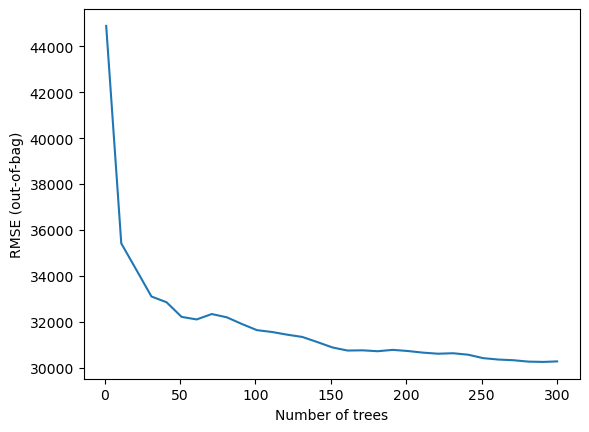

In [16]:
# Evaluate model on the Out of bag data and validation dataset
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [17]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1006, accuracy=None, loss=None, rmse=30283.24594867168, ndcg=None, aucs=None, auuc=None, qini=None)

In [18]:
evaluation = rf.evaluate(x = valid_ds, return_dict = True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00 - mse: 697233920.0000
loss: 0.0000
mse: 697233920.0000


In [19]:
# Variable importances
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_AS_ROOT
	 NUM_NODES
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE


---
**Observations:** By default, the list above is sorted from the most important to the least. 

---

In [20]:
inspector.variable_importances()["SUM_SCORE"]

[("OverallQual" (1; #62), 493590223838949.6),
 ("ExterQual" (4; #22), 216510247075274.0),
 ("Neighborhood" (4; #59), 195858651223360.56),
 ("GrLivArea" (1; #38), 189219094770752.1),
 ("GarageCars" (1; #32), 134949126642277.88),
 ("TotalBsmtSF" (1; #73), 77708240678727.6),
 ("GarageArea" (1; #31), 70493186770637.4),
 ("1stFlrSF" (1; #0), 60224417639659.67),
 ("YearBuilt" (1; #76), 40624305012033.69),
 ("BsmtFinSF1" (1; #8), 39380917544947.78),
 ("KitchenQual" (4; #44), 32540771671652.75),
 ("LotArea" (1; #47), 31602569109771.133),
 ("2ndFlrSF" (1; #1), 30303107013299.5),
 ("TotRmsAbvGrd" (1; #72), 30063953832106.688),
 ("BsmtQual" (4; #14), 18240258307246.0),
 ("FullBath" (1; #29), 11821059205070.75),
 ("Exterior2nd" (4; #24), 11303807279939.312),
 ("GarageYrBlt" (1; #37), 10573181214013.562),
 ("Exterior1st" (4; #23), 10098038258446.094),
 ("YearRemodAdd" (1; #77), 10054632563107.062),
 ("Fireplaces" (1; #27), 8923408228796.625),
 ("BsmtUnfSF" (1; #15), 8567574663381.781),
 ("OpenPorch

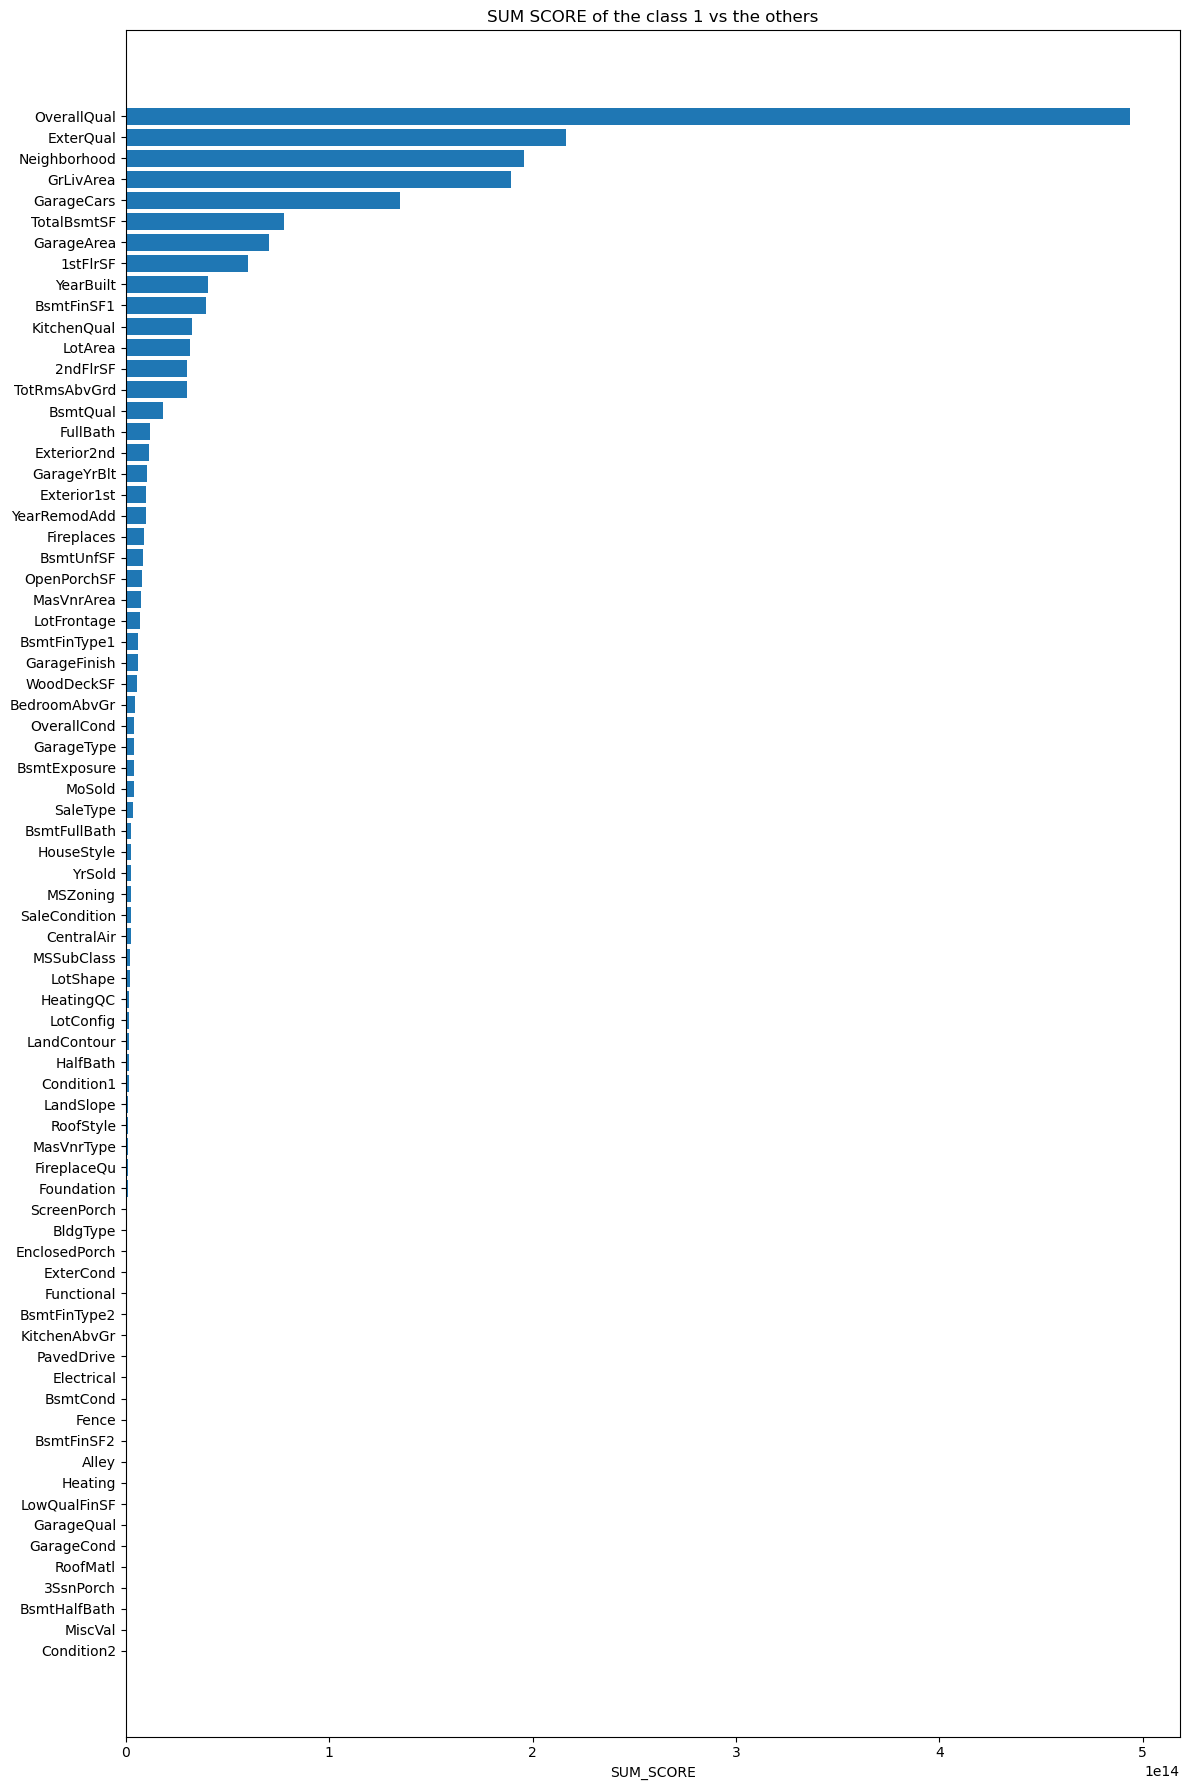

In [21]:
plt.figure(figsize = (12, 18))

variable_importance_metric = "SUM_SCORE"
variable_importances = inspector.variable_importances()[variable_importance_metric]

feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label = [str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

plt.xlabel(variable_importance_metric)
plt.title("SUM SCORE of the class 1 vs the others")
plt.tight_layout()
plt.show()

---
**Observations:** This graph clearly shows what features are the most important: The overall quality, Neighborhood and the above ground living area, to name the first three.

---

In [22]:
# Predict on test data using the model
test_data = pd.read_csv("test.csv")
ids = test_data.pop("Id")

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({"Id": ids, "SalePrice": preds.squeeze()})
output.head()

2/2 [==============================] - 0s 12ms/step


,Id,SalePrice
0,1461,127200.625000
1,1462,155751.703125
2,1463,178869.500000
3,1464,181391.328125
4,1465,206392.125000


In [23]:
sample_submission_df = pd.read_csv("sample_submission.csv")
sample_submission_df["SalePrice"] = rf.predict(test_ds)
sample_submission_df.head()

2/2 [==============================] - 0s 12ms/step


,Id,SalePrice
0,1461,127200.625000
1,1462,155751.703125
2,1463,178869.500000
3,1464,181391.328125
4,1465,206392.125000


In [24]:
MSE = np.square(np.subtract(output["SalePrice"],sample_submission_df["SalePrice"])).mean() 
MSE

0.0